<a href="https://colab.research.google.com/github/charlesmartin14/2020_benfords/blob/main/WWRegularizationExperimentsRepo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WW Regularizer Experiments

In [1]:
from getpass import getpass
token = getpass('Enter your GitHub token: ')

Enter your GitHub token: ··········


In [13]:
!git clone https://{token}@github.com/CalculatedContent/WW_Regularizer_Experiments.git
%cd /content/WW_Regularizer_Experiments


Cloning into 'WW_Regularizer_Experiments'...
remote: Enumerating objects: 322, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 322 (delta 38), reused 22 (delta 22), pack-reused 238 (from 3)
Receiving objects: 100% (322/322), 247.43 KiB | 1.96 MiB/s, done.
Resolving deltas: 100% (146/146), done.
/content/WW_Regularizer_Experiments


In [3]:
!git pull

Already up to date.


In [14]:
import os, pathlib

import sys
sys.path.append("/content/WW_Regularizer_Experiments")

# Choose estimator: soft_mle | hill | quantile
os.environ["WW_ESTIMATOR"] = "soft_mle"

# Model & outputs
os.environ["MODEL_ID"]    = "prajjwal1/bert-tiny"
os.environ["OUTPUT_DIR"]  = "/content/ww_outputs"

# Mirror artifacts to Drive (optional)
drive_dir = "/content/drive/MyDrive/wwruns/run_demo"
pathlib.Path(drive_dir).mkdir(parents=True, exist_ok=True)
os.environ["DRIVE_DIR"]   = drive_dir

# Leave blank for time-based seed, or set to e.g. "42"
os.environ["WW_SEED"]     = ""


In [5]:
!pip install -q weightwatcher transformers datasets


In [6]:
!pip install -e .


Obtaining file:///content/WW_Regularizer_Experiments
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ww-regularizer-experiments (pyproject.toml) ... done
  Created wheel for ww-regularizer-experiments: filename=ww_regularizer_experiments-0.1.0-0.editable-py3-none-any.whl size=4203 sha256=c0d92cb7c5bc956f6e45c69f8ae44014e03da50bca5b97b8b4eca006071f93a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-6iwautgw/wheels/f3/89/b9/42f42e018a623fa453c25f98f5ea231d150a66fa3a9f225a14
Successfully built ww-regularizer-experiments
  Attempting uninstall: ww-regularizer-experiments
    Found existing installation: ww-regularizer-experiments 0.1.0
    Uninstalling ww-regularizer-experiments-0.1.0:
      Successfully uninstalled ww-regularizer-experiments-0.1.0


In [7]:
import os, sys, subprocess
os.environ["WW_ESTIMATOR"] = "none"          # ignored for baseline
os.environ["MODEL_ID"]     = "prajjwal1/bert-tiny"
os.environ["OUTPUT_DIR"]   = "outputs_baseline"
os.environ["WW_SEED"]      = ""              # blank => time-based seed

# Launch the runner with baseline variants only
from wwreg.runner import ExperimentRunner
from wwreg.datasets import load_glue_mrpc
from wwreg.core import HP_PRESETS

runner = ExperimentRunner(
    model_id=os.environ["MODEL_ID"],
    num_labels=2,
    dataset_loader=load_glue_mrpc,
    output_dir=os.environ["OUTPUT_DIR"]
)

paths = runner.run(
    variants=["AdamW", "Adam", "SGD"],     # baseline only
    ww_reg=None,                           # <- disable regularizer
    hp_presets=HP_PRESETS,
    seed=None,
    per_run_seeds=[None,None,None],
    dataset_kwargs={"max_len": 128},
    warmup_optimizer="AdamW",
    enable_weightwatcher=True,             # keep true if you still want WW analysis
    ww_options=dict(savefig=False, plot=False),
    estimator_name="baseline"
)
print(paths)

experiment_id=20251021-035315-8d930d5b
[WW] No seed provided — using current time as seed: 1761018795


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You

Step,Training Loss
50,0.650000
100,0.613100


[WW] No seed provided — using current time as seed: 1761018801


[WW] No seed provided — using current time as seed: 1761018814


[WW] No seed provided — using current time as seed: 1761018829


training_df keys: ['epoch', 'eval_accuracy', 'eval_f1', 'eval_loss', 'experiment', 'variant']
{'evals_feather': 'outputs_baseline/evals.feather', 'ww_epoch_feather': 'outputs_baseline/ww_epoch_details.feather', 'layer_id_map_feather': 'outputs_baseline/layer_id_map.feather', 'merged_feather': 'outputs_baseline/merged_all.feather', 'manifest': 'outputs_baseline/manifest.json'}


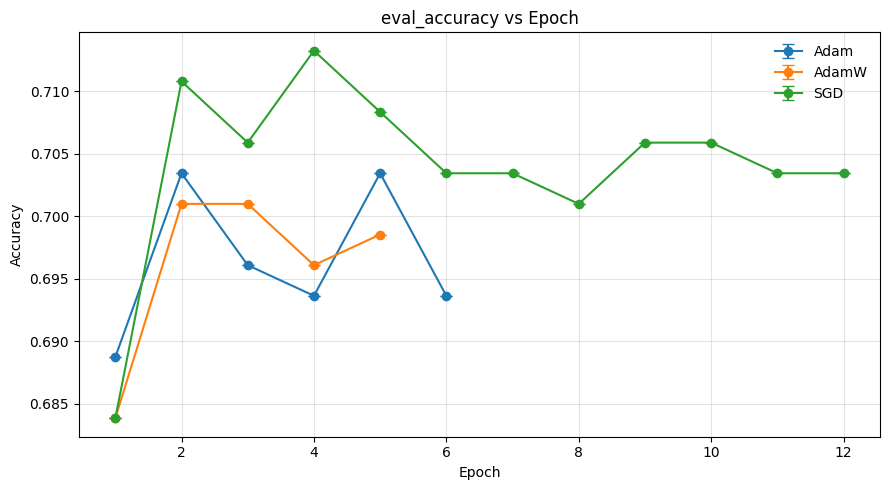

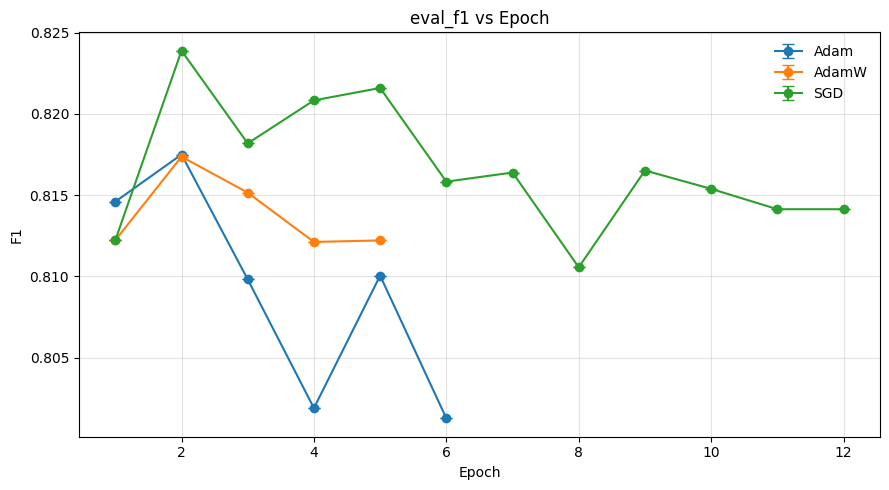

In [8]:
from wwreg.plotting import plot_results

# display inline
plot_results(
    "outputs_baseline",                 # use positional or source="outputs_baseline"
    variants=["Adam", "AdamW", "SGD"],
    metrics=["eval_accuracy", "eval_f1"],
    layerwise=False,
    show=True                           # <-- needed to draw the figures
);


In [9]:
# Train baseline + regularized together for 5 epochs (same output dir)
import os
os.environ["MODEL_ID"]   = "prajjwal1/bert-tiny"
os.environ["OUTPUT_DIR"] = "outputs_compare_5ep"
os.environ["WW_SEED"]    = ""

REG_KIND = "hill"  # or "soft_mle" / "quantile"

from wwreg.core import HP_PRESETS
from wwreg.runner import ExperimentRunner
from wwreg.datasets import load_glue_mrpc
from wwreg.regularizers.hill import HillWWRegularizer, HillWWConfig
from wwreg.regularizers.soft_mle import SoftMLEWWRegularizer, SoftMLEWWConfig
from wwreg.regularizers.quantile import QuantileWWRegularizer, QuantileWWConfig

HP_PRESETS["AdamW"].epochs = 5

if REG_KIND == "hill":
    ww_reg = HillWWRegularizer(HillWWConfig(reg_lambda=5e-3, target_alpha=2.0))
elif REG_KIND == "soft_mle":
    ww_reg = SoftMLEWWRegularizer(SoftMLEWWConfig(reg_lambda=5e-4, target_alpha=2.0))
else:
    ww_reg = QuantileWWRegularizer(QuantileWWConfig(reg_lambda=5e-3, target_alpha=2.0))

runner = ExperimentRunner(
    model_id=os.environ["MODEL_ID"],
    num_labels=2,
    dataset_loader=load_glue_mrpc,
    output_dir=os.environ["OUTPUT_DIR"]
)

_ = runner.run(
    variants=["AdamW","AdamW+reg"],      # <-- baseline + experiment
    ww_reg=ww_reg,                       # used only for +reg
    hp_presets=HP_PRESETS,
    seed=None,
    per_run_seeds=[None,None],
    dataset_kwargs={"max_len":128},
    warmup_optimizer="AdamW",
    enable_weightwatcher=True,
    ww_options=dict(savefig=False, plot=False),
    estimator_name=REG_KIND,
)


experiment_id=20251021-035411-ab860863
[WW] No seed provided — using current time as seed: 1761018851


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/WW_Regularizer_Experiments/wwreg/runner.py:326: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  warm_trainer = Trainer(


Step,Training Loss
50,0.666500
100,0.636600


[WW] No seed provided — using current time as seed: 1761018858


[WW] No seed provided — using current time as seed: 1761018871


TailAdapt: epoch 1 — updated 9 layers (alpha_reg≈1.966; alpha_WW≈5.441; tail≈98.2%)
TailAdapt: epoch 2 — updated 9 layers (alpha_reg≈1.976; alpha_WW≈5.441; tail≈98.2%)
TailAdapt: epoch 3 — updated 8 layers (alpha_reg≈1.991; alpha_WW≈5.875; tail≈97.9%)
TailAdapt: epoch 4 — updated 8 layers (alpha_reg≈1.998; alpha_WW≈5.873; tail≈97.9%)
TailAdapt: epoch 5 — updated 8 layers (alpha_reg≈1.999; alpha_WW≈5.874; tail≈97.9%)
training_df keys: ['epoch', 'eval_accuracy', 'eval_f1', 'eval_loss', 'experiment', 'variant']
reg_ww_df keys: ['epoch', 'experiment', 'variant', 'layer', 'hill_alpha', 'tail_k_min', 'tail_k_max', 'n_svals', 'layer_id']


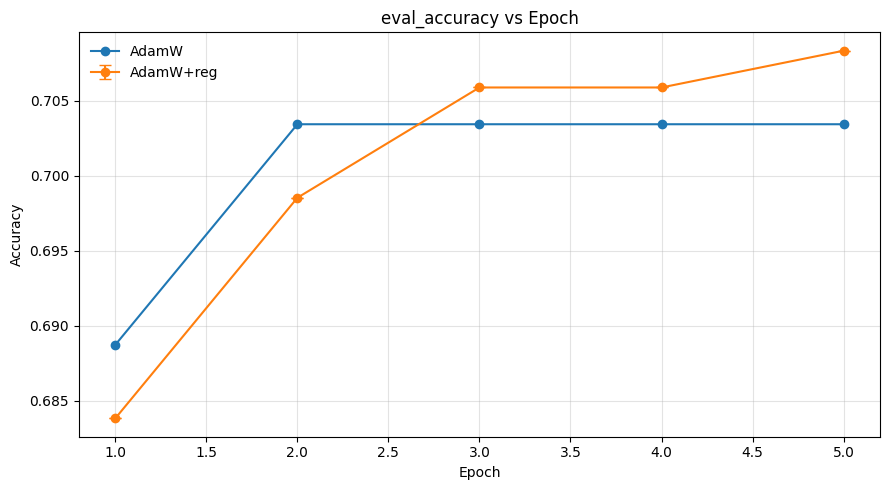

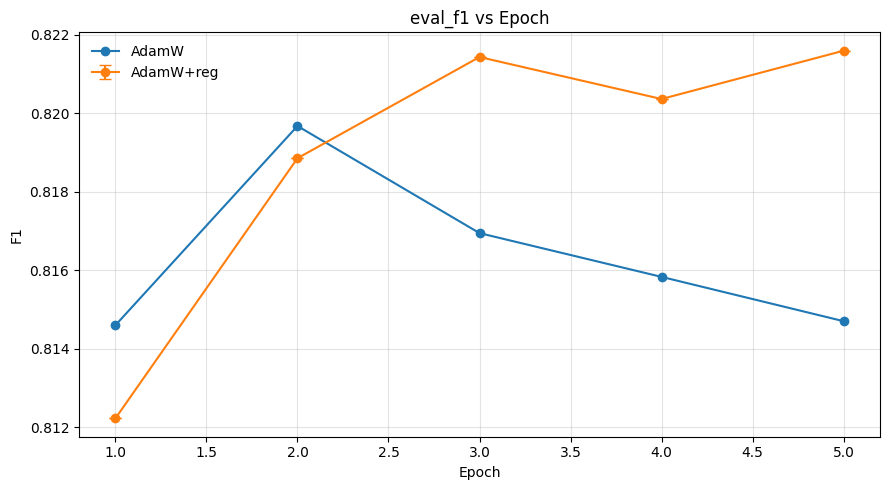

In [10]:
plot_results(
    ["outputs_compare_5ep"],
    variants=["AdamW", "AdamW+reg"],
    metrics=["eval_accuracy", "eval_f1"],
    show=True,
);

In [15]:
# Overlay baseline vs regularized (robust to missing/odd merge cases)
import os, pandas as pd, matplotlib.pyplot as plt

BASE = os.environ.get("OUTPUT_DIR", "outputs_compare_5ep")

def _load_frames(base_dir):
    merged_path = os.path.join(base_dir, "merged_all.feather")
    evals_path  = os.path.join(base_dir, "evals.feather")
    merged = pd.read_feather(merged_path) if os.path.exists(merged_path) else pd.DataFrame()
    evals  = pd.read_feather(evals_path)  if os.path.exists(evals_path)  else pd.DataFrame()
    return merged, evals

def _pick_key(df):
    # prefer explicit 'variant'; else fall back to 'experiment'
    return "variant" if "variant" in df.columns else ("experiment" if "experiment" in df.columns else None)

def _slice_variant(df, key, name):
    if key is None or df.empty:
        return pd.DataFrame()
    col = df[key].astype(str)
    # exact match first; if merged uses long experiment IDs, allow suffix match
    m = df[col == name]
    if m.empty:
        m = df[col.str.endswith(name, na=False)]
    # also allow directory-style naming "AdamW_reg" in case "+reg" was normalized
    if name == "AdamW+reg" and m.empty:
        m = df[col.str.endswith("AdamW_reg", na=False)]
    return m

def overlay_two(merged, evals, metric, ylabel, title):
    # choose a source that contains both variants; prefer merged
    def has_both(df, key):
        return key is not None and not df.empty and (
            df[key].astype(str).eq("AdamW").any() or df[key].astype(str).str.endswith("AdamW").any()
        ) and (
            df[key].astype(str).eq("AdamW+reg").any() or
            df[key].astype(str).str.endswith("AdamW+reg").any() or
            df[key].astype(str).str.endswith("AdamW_reg").any()
        )

    src = merged.copy()
    k   = _pick_key(src)
    if not has_both(src, k) or metric not in src.columns:
        src = evals.copy()
        k   = _pick_key(src)

    if src.empty or metric not in src.columns or k is None:
        print(f"[skip] cannot plot '{metric}' — missing data/keys")
        return

    a = _slice_variant(src, k, "AdamW")       .sort_values("epoch")
    r = _slice_variant(src, k, "AdamW+reg")   .sort_values("epoch")

    if a.empty and r.empty:
        print(f"[skip] '{metric}' not available for AdamW/AdamW+reg")
        return

    plt.figure(figsize=(8,5))
    if not a.empty:
        plt.plot(a["epoch"], a[metric], marker="o", label="AdamW")
    if not r.empty:
        plt.plot(r["epoch"], r[metric], marker="o", label="AdamW+reg")
    plt.xlabel("Epoch"); plt.ylabel(ylabel); plt.title(title)
    plt.grid(True, alpha=0.3); plt.legend(frameon=False); plt.tight_layout(); plt.show()

merged, evals = _load_frames(BASE)
overlay_two(merged, evals, "eval_accuracy", "Accuracy", f"AdamW vs AdamW+reg — Accuracy ({REG_KIND}, 5 epochs)")
overlay_two(merged, evals, "eval_f1",       "F1 Score", f"AdamW vs AdamW+reg — F1 ({REG_KIND}, 5 epochs)")

[skip] cannot plot 'eval_accuracy' — missing data/keys
[skip] cannot plot 'eval_f1' — missing data/keys


experiment_id=20251021-035828-bfbe40de
[WW] No seed provided — using current time as seed: 1761019108


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/WW_Regularizer_Experiments/wwreg/runner.py:326: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  warm_trainer = Trainer(


Step,Training Loss
50,0.700600
100,0.640100


[WW] No seed provided — using current time as seed: 1761019113


[WW] No seed provided — using current time as seed: 1761019164


TailAdapt: epoch 1 — updated 8 layers (alpha_reg≈1.926; alpha_WW≈5.892; tail≈97.9%)
TailAdapt: epoch 2 — updated 8 layers (alpha_reg≈1.915; alpha_WW≈5.892; tail≈97.9%)
TailAdapt: epoch 3 — updated 10 layers (alpha_reg≈1.906; alpha_WW≈5.090; tail≈98.4%)
TailAdapt: epoch 4 — updated 8 layers (alpha_reg≈1.998; alpha_WW≈5.891; tail≈97.9%)
TailAdapt: epoch 5 — updated 8 layers (alpha_reg≈1.993; alpha_WW≈5.889; tail≈97.9%)
TailAdapt: epoch 6 — updated 8 layers (alpha_reg≈1.999; alpha_WW≈5.887; tail≈97.9%)
TailAdapt: epoch 7 — updated 8 layers (alpha_reg≈1.995; alpha_WW≈5.886; tail≈97.9%)
TailAdapt: epoch 8 — updated 8 layers (alpha_reg≈1.997; alpha_WW≈5.885; tail≈97.9%)
TailAdapt: epoch 9 — updated 8 layers (alpha_reg≈1.994; alpha_WW≈5.883; tail≈97.9%)
TailAdapt: epoch 10 — updated 8 layers (alpha_reg≈1.993; alpha_WW≈5.881; tail≈97.9%)
TailAdapt: epoch 11 — updated 8 layers (alpha_reg≈1.995; alpha_WW≈5.882; tail≈97.9%)
TailAdapt: epoch 12 — updated 8 layers (alpha_reg≈1.993; alpha_WW≈5.880; 

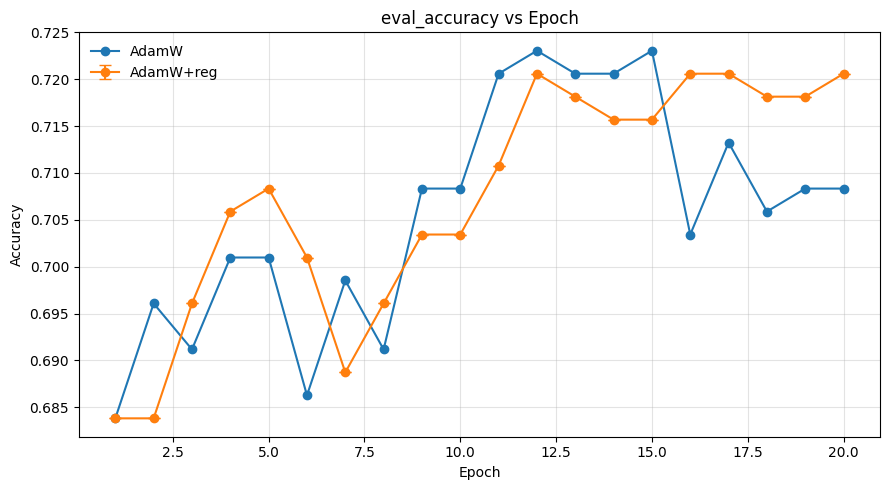

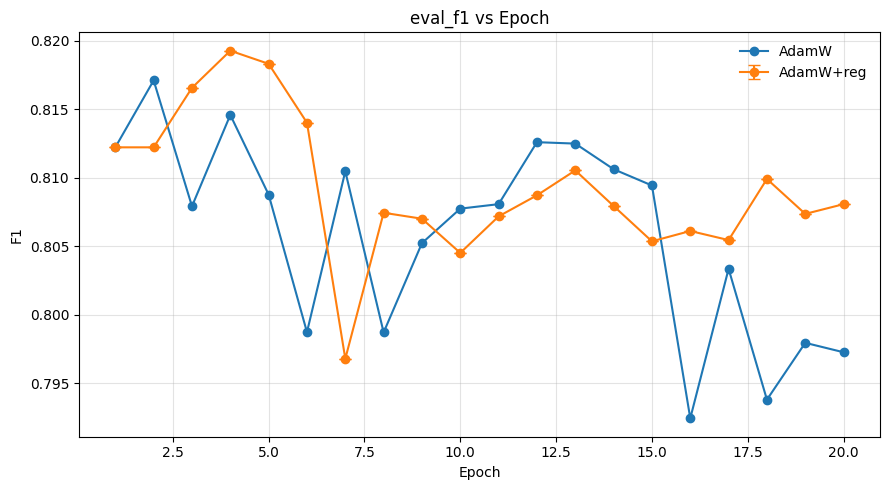

{'data':                              experiment    variant  epoch  label_id estimator  \
 0        20251021-035828-bfbe40de-AdamW      AdamW      1         0      None   
 1        20251021-035828-bfbe40de-AdamW      AdamW      2         0      None   
 2        20251021-035828-bfbe40de-AdamW      AdamW      3         0      None   
 3        20251021-035828-bfbe40de-AdamW      AdamW      4         0      None   
 4        20251021-035828-bfbe40de-AdamW      AdamW      5         0      None   
 ..                                  ...        ...    ...       ...       ...   
 275  20251021-035828-bfbe40de-AdamW_reg  AdamW+reg     20         0      hill   
 276  20251021-035828-bfbe40de-AdamW_reg  AdamW+reg     20         0      hill   
 277  20251021-035828-bfbe40de-AdamW_reg  AdamW+reg     20         0      hill   
 278  20251021-035828-bfbe40de-AdamW_reg  AdamW+reg     20         0      hill   
 279  20251021-035828-bfbe40de-AdamW_reg  AdamW+reg     20         0      hill   
 
      

In [16]:
# --- CONFIG -------------------------------------------------
import os

os.environ["MODEL_ID"]   = "prajjwal1/bert-tiny"
os.environ["OUTPUT_DIR"] = "outputs_tailreset_6ep"
os.environ["WW_SEED"]    = ""  # use time-based seed

REG_KIND = "hill"  # choose from: hill | soft_mle | quantile
EPOCHS   = 20

# --- IMPORTS ------------------------------------------------
from wwreg.core import HP_PRESETS
from wwreg.runner import ExperimentRunner
from wwreg.datasets import load_glue_mrpc
from wwreg.regularizers.hill import HillWWRegularizer, HillWWConfig
from wwreg.regularizers.soft_mle import SoftMLEWWRegularizer, SoftMLEWWConfig
from wwreg.regularizers.quantile import QuantileWWRegularizer, QuantileWWConfig

# --- BUILD REGULARIZER --------------------------------------
HP_PRESETS["AdamW"].epochs = EPOCHS

if REG_KIND == "hill":
    ww_reg = HillWWRegularizer(HillWWConfig(reg_lambda=5e-3, target_alpha=2.0))
elif REG_KIND == "soft_mle":
    ww_reg = SoftMLEWWRegularizer(SoftMLEWWConfig(reg_lambda=5e-4, target_alpha=2.0))
elif REG_KIND == "quantile":
    ww_reg = QuantileWWRegularizer(QuantileWWConfig(reg_lambda=5e-3, target_alpha=2.0))
else:
    raise ValueError("REG_KIND must be one of: 'hill', 'soft_mle', 'quantile'")

# --- RUNNER -------------------------------------------------
runner = ExperimentRunner(
    model_id=os.environ["MODEL_ID"],
    num_labels=2,
    dataset_loader=load_glue_mrpc,
    output_dir=os.environ["OUTPUT_DIR"]
)

# Run both: baseline and +reg (with tail resets enabled automatically)
_ = runner.run(
    variants=["AdamW", "AdamW+reg"],
    ww_reg=ww_reg,
    hp_presets=HP_PRESETS,
    seed=None,
    per_run_seeds=[None, None],
    dataset_kwargs={"max_len": 128},
    warmup_optimizer="AdamW",
    enable_weightwatcher=True,  # ensures WW + tail reset hooks are active
    ww_options=dict(savefig=False, plot=False),
    estimator_name=REG_KIND,
)

# --- VERIFY METRICS EXIST -----------------------------------
import pandas as pd
BASE = os.environ["OUTPUT_DIR"]
merged = pd.read_feather(f"{BASE}/merged_all.feather")

print("Variants present:", merged["variant"].unique().tolist())
print(
    merged.groupby("variant")[["eval_accuracy", "eval_f1"]]
    .apply(lambda df: df.notna().sum())
)



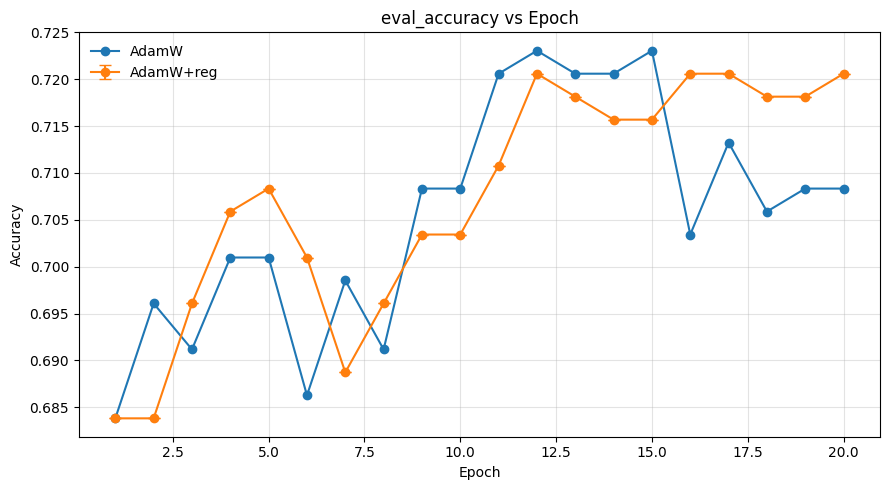

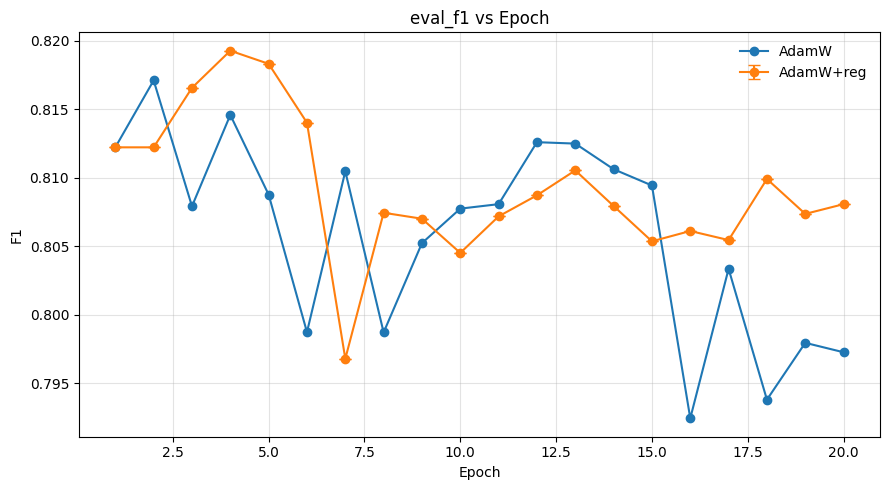

In [17]:
# --- BASIC PLOTS --------------------------------------------
from wwreg.plotting import plot_results

plot_results(
    BASE,
    metrics=["eval_accuracy", "eval_f1"],
    layerwise=False,
    show=True
);